# Cluster temperature and salinity data with k-means

k-means is useful in simplifying large datasets so that you have several smaller datasets with similar characteristics. This subsetting could be useful in finding distinct patterns

**main assumptions**:
1. assume the joint distribution of features within each cluster is spherical: this means that features within a cluster have equal variance, and also features are independent of each other;
2. clusters have similar density

**pros**
1. simple, easy to implement and identify unknown groups of data from complex data sets;
3. easy to interpret the clustering results;

**cons**
1. number of cluster centers need to be predefined
2. don't handle outliers

---

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


Import pickle data file generated by *02_EAA.ipynb*

In [2]:
import pickle

df_ts = pickle.load( open( "save_df_t.p", "rb" ) )

In [3]:
df_ts.head()

,PLATFORM_NUMBER,WMO_INST_TYPE,LATITUDE,LONGITUDE,SOURCE_x,TEMP0,TEMP1000,TEMP2000,DATE,SOURCE_y,PSAL0,PSAL1000,PSAL2000
3463,6901923,846,62.333950,-15.033000,OA_CORA5.2_20180115_dat_TEMP.nc,8.387501,4.629461,NaN,2017-12-05 22:52:30.000000000,OA_CORA5.2_20180115_dat_PSAL.nc,35.033997,34.966255,NaN
3467,6901205,846,28.753000,-27.372002,OA_CORA5.2_20180115_dat_TEMP.nc,23.041900,8.138038,NaN,2017-12-05 13:52:30.000000000,OA_CORA5.2_20180115_dat_PSAL.nc,37.224700,35.367650,NaN
3469,6901155,863,34.022949,-26.106701,OA_CORA5.2_20180115_dat_TEMP.nc,21.802500,9.112900,NaN,2017-12-06 01:01:52.500000000,OA_CORA5.2_20180115_dat_PSAL.nc,36.911000,35.531902,NaN
3470,6901206,846,26.306000,-30.769501,OA_CORA5.2_20180115_dat_TEMP.nc,24.283500,7.684639,NaN,2017-12-06 14:06:33.750000000,OA_CORA5.2_20180115_dat_PSAL.nc,37.487050,35.300575,NaN
3471,5904769,846,44.585499,-30.964998,OA_CORA5.2_20180115_dat_TEMP.nc,17.018276,5.400150,NaN,2017-12-06 15:39:22.500000000,OA_CORA5.2_20180115_dat_PSAL.nc,36.054924,35.040200,NaN


Subsample dataframe

In [4]:
df_ts = df_ts[['LONGITUDE','LATITUDE','TEMP1000','PSAL1000']].dropna()
Xloc = df_ts[['LONGITUDE','LATITUDE']];
X = df_ts[['TEMP1000','PSAL1000']]

## Test for n_clusters=4

#### without normalization

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

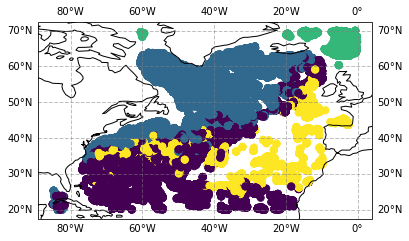

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(Xloc.iloc[:, 0], Xloc.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')


**To give equal importance to all features, we need to scale them.**

#### with MinMaxScaler

In [7]:
scaler = MinMaxScaler()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,kmeans)

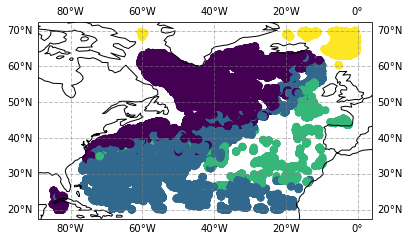

In [8]:
# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Plot the cluster labels
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.scatter(Xloc.iloc[:, 0], Xloc.iloc[:, 1], c=labels, s=50, cmap='viridis')


#### with StandardScaler()

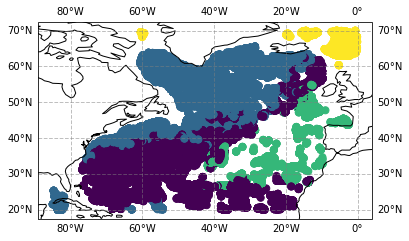

In [9]:
scaler = StandardScaler()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,kmeans)

# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Plot the cluster labels
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.scatter(Xloc.iloc[:, 0], Xloc.iloc[:, 1], c=labels, s=50, cmap='viridis')


**Here the standardisation StandardScaler() and MinMaxScaler appear to give better the same results, less influence by the geographical weight of the coordinates.
It seems to match also with the knowledge we have of the different wahter mass existing in the region (e.g. Subtropical, Mediterranean Waters, Subpolar gyre / Arctic)**

StandardScaler() transform each value in the column to range about the mean 0 and standard deviation 1, ie, each value will is normalised by subtracting the mean and dividing by standard deviation. Ir seems appropriate for data with normal distribution.

## Calculate the optimal number of cluters

### Elbow method

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

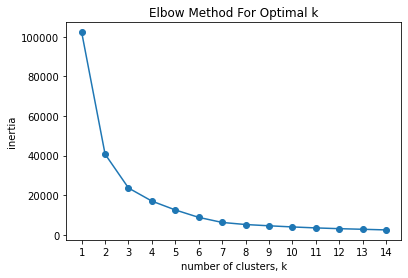

In [10]:
inertias = []
ks = range(1,15)
for k in ks:
    km = KMeans(n_clusters=k)
    pipeline = make_pipeline(scaler,km)
    pipeline.fit(X)
    # Append the inertia to the list of inertias
    inertias.append(km.inertia_) 
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Method For Optimal k')
plt.show()


Elbow method: Find the optimal number of cluster so the total intra-cluster variation is minimized

### Avg. silhouette method

it measures the quality of a clustering. That is, it determines how well each object lies within its cluster. A high average silhouette width indicates a good clustering.

In [ ]:
from sklearn.metrics import silhouette_score

sil_score = []
ks = range(2,9)
for k in ks:
    km = KMeans(n_clusters=k)
    pipeline = make_pipeline(scaler,km)
    pipeline.fit(X)
    label=pipeline.predict(X)
    # Append the inertia to the list of inertias
    sil_score.append(silhouette_score(X, label)) 
    
# Plot ks vs inertias
plt.plot(ks, sil_score, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette_score')
plt.xticks(ks)
plt.title('Average Silhouette method For Optimal k')
plt.show()


 The optimal number of clusters k is the one that maximize the average silhouette, which appears to be n=4 clusters

### Computation for n_cluster=4

In [ ]:
kmeans = KMeans(n_clusters=4)

scaler = StandardScaler()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,kmeans)

# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Plot the cluster labels
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.scatter(Xloc.iloc[:, 0], Xloc.iloc[:, 1], c=labels, s=50, cmap='viridis')

#### Temperature-salinity diagram

In [ ]:
import seaborn as sns
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})

scatplot=sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,0],
                hue=labels,palette='deep',
                linewidth=0, alpha = 0.7);
scatplot.legend(loc=2)

### Things to do next

1. Load more years (Here we only used 2018 data)
2. For each observation, load the whole verticale profile, not only the data at 1000m depth -> Need to do some PCA to reduce the vertical dimension to the optimal number (from 200 vertical data points for each observation we may end up with 10)
3. Try other clustering alogrithms which could be more appropriate to take into  consideration the mixing existing in the ocean (e.g. GMM) 

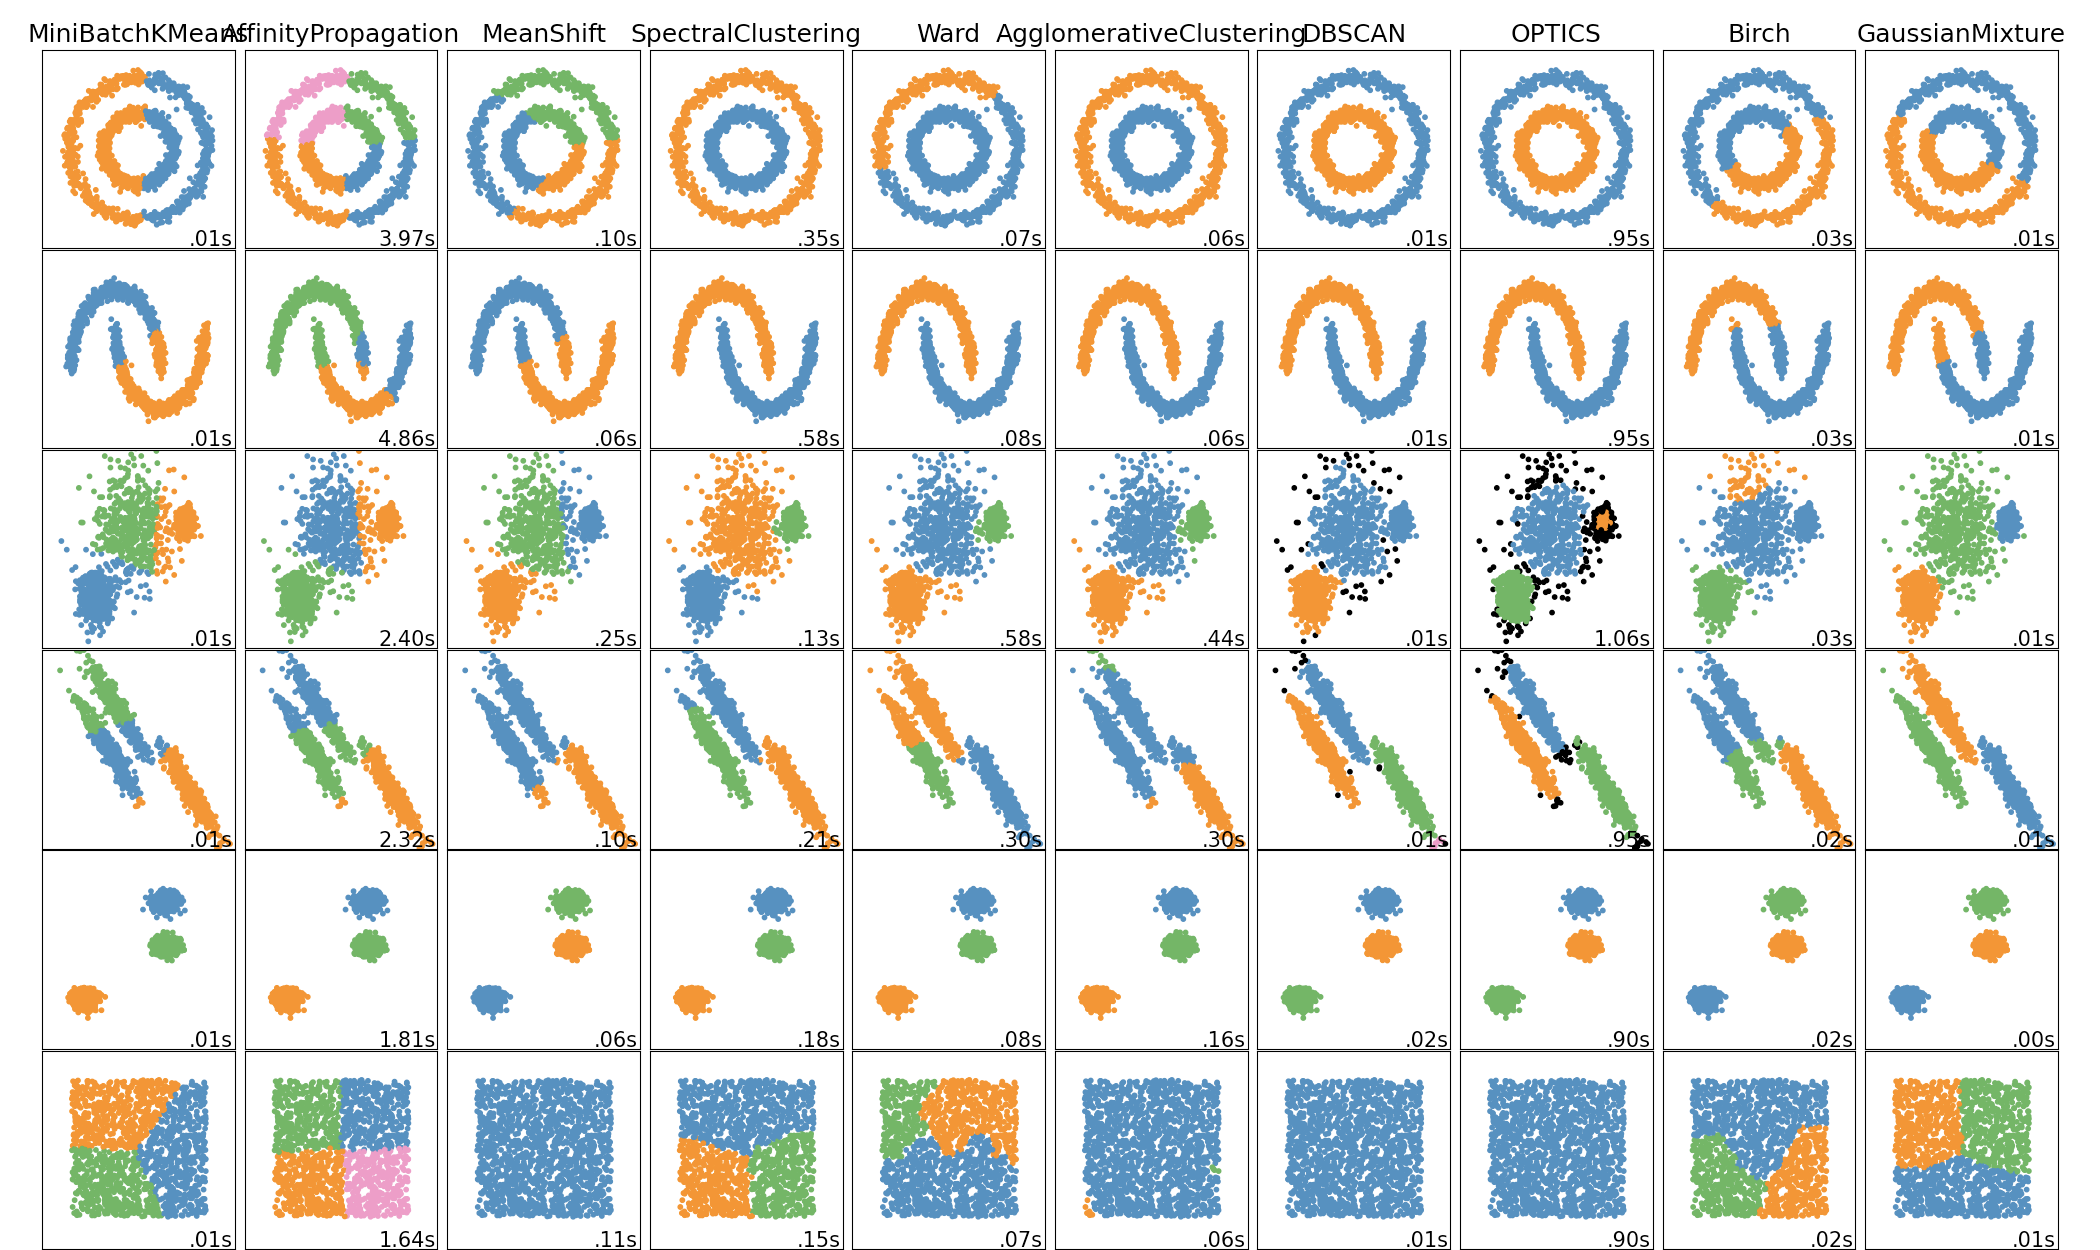
Comparison of several cluster algorithms from [Scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

### Gaussian Mixture Models

Gaussian mixture models can be used to cluster unlabeled data in much the same way as k-means. There are, however, a couple of advantages to using Gaussian mixture models over k-means.

First and foremost, k-means does not account for variance. In two dimensions, variance (covariance to be exact) determines the shape of the distribution.

The second difference between k-means and Gaussian mixture models is that **GMM performs soft classification** while k-means performs hard classification. In other words, k-means tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters.

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4).fit(X)

scaler = StandardScaler()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,gmm)

# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Plot the cluster labels
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

my_cmap = ListedColormap(sns.color_palette("Dark2").as_hex())
plt.scatter(Xloc.iloc[:, 0], Xloc.iloc[:, 1], c=labels, s=50, cmap=my_cmap)

In [ ]:
scatplot=sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,0],
                hue=labels,palette=my_cmap,
                linewidth=0, alpha = 0.7);
scatplot.legend(loc=2)